In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import math

In [3]:
dfdata = pd.read_csv('/content/drive/MyDrive/NLMH_OnkiemTra/Chap2_Classification_DecisionTree/drug.csv')
# dfdata.head()
dfdata

,Patient ID,Age,Sex,BP,Cholesterol,Drug
0,p1,Young,F,High,Normal,Drug A
1,p2,Young,F,High,High,Drug A
2,p3,Middle-age,F,High,Normal,Drug B
3,p4,Senior,F,Normal,Normal,Drug B
4,p5,Senior,M,Low,Normal,Drug B
5,p6,Senior,M,Low,High,Drug A
6,p7,Middle-age,M,Low,High,Drug B
7,p8,Young,F,Normal,Normal,Drug A
8,p9,Young,M,Low,Normal,Drug B
9,p10,Senior,M,Normal,Normal,Drug B


In [4]:
data_train=dfdata.iloc[:-1,1:]
# data_train.head(5)
data_train

,Age,Sex,BP,Cholesterol,Drug
0,Young,F,High,Normal,Drug A
1,Young,F,High,High,Drug A
2,Middle-age,F,High,Normal,Drug B
3,Senior,F,Normal,Normal,Drug B
4,Senior,M,Low,Normal,Drug B
5,Senior,M,Low,High,Drug A
6,Middle-age,M,Low,High,Drug B
7,Young,F,Normal,Normal,Drug A
8,Young,M,Low,Normal,Drug B
9,Senior,M,Normal,Normal,Drug B


In [5]:
attrs = data_train.columns[:]
attrs

Index(['Age', 'Sex', 'BP', 'Cholesterol', 'Drug'], dtype='object')

In [6]:
class Tree:
  def __init__(self,observationIDs,features,currLvl=0,subTree={},bestFeature=None,majorityLabel=None,parentMajorityLabel=None):
    self.observationIDs = observationIDs
    self.features = features
    self.currLvl = currLvl
    self.subTree = subTree
    self.bestFeature = bestFeature
    self.majorityLabel = majorityLabel
    self.parentMajorityLabel = parentMajorityLabel
    self.setBestFeatureID(bestFeature)

  def setBestFeatureID(self, feature):
      if feature is None:
          self.bestFeatureID = None
          return
      idx = None
      if feature == 'Age':
          idx = 0
      elif feature == 'Sex':
          idx = 1
      elif feature == 'BP':
          idx = 2
      elif feature == 'Cholesterol':  # Thêm điều kiện cho 'Cholesterol'
          idx = 3
      self.bestFeatureID = int(idx)

In [7]:
def predict(tree, obs):
	if tree.bestFeature == None:
		return tree.majorityLabel
	featVal = obs[tree.bestFeature]
	if not featVal in tree.subTree: # val with no subtree
		return tree.majorityLabel
	else: # recurse on subtree
		return predict(tree.subTree[featVal], obs)

In [8]:
def displayDecisionTree(tree):
	print('\t'*tree.currLvl + '(lvl {}) {}'.format(tree.currLvl,tree.majorityLabel))
	if tree.bestFeature == None:
		return

	print('\t'*tree.currLvl + '{}'.format(tree.bestFeature) + ': ')
	for [val,subTree] in sorted(tree.subTree.items()):
		print('\t'*(tree.currLvl+1) + 'choice: {}'.format(val))
		displayDecisionTree(subTree)

In [9]:
def Entropy(ns):
	entropy = 0.0
	total = sum(ns)
	for x in ns:
		entropy += -1.0*x/total*math.log(1.0*x/total,2)
	return entropy

In [10]:
def IG(observationIDs, feature, dfdata):
	# get smaller dataframe
	df = dfdata.loc[list(observationIDs)]
	# populate counts for Wins/Losses for each category of the feature
	labelCountDict = {}
	valueLabelCountDict = {}
	for index, row in df.iterrows():
		label = row['Drug']
		if not label in labelCountDict:
			labelCountDict[label] = 0 # this specific label was not found so insert 0 count
		labelCountDict[label] += 1
		featureValue = row[feature]
		if not featureValue in valueLabelCountDict:
			valueLabelCountDict[featureValue] = {} # this specific feature value not found so insert empty dict
		if not label in valueLabelCountDict[featureValue]:
			valueLabelCountDict[featureValue][label] = 0 # this specific label was not found for this feature value so insert 0 count
		valueLabelCountDict[featureValue][label] += 1

	ns = []
	for [label,count] in labelCountDict.items():
		ns.append(count)

	H_Y = Entropy(ns)

	H_Y_X = 0.0
	for [featureValue, labelCountDict] in valueLabelCountDict.items():
		nsHYX = []
		for [label,count] in labelCountDict.items():
			nsHYX.append(count)
		H_Y_X += 1.0*sum(nsHYX)/len(df)*Entropy(nsHYX)
	return H_Y - H_Y_X

In [11]:
def GR(observationIDs, feature,dfdata):
	ig = IG(observationIDs,feature, dfdata)
	if ig == 0:
		return 0
	df = dfdata.loc[list(observationIDs)]
	valueLabelDict = {}
	for index, row in df.iterrows():
		label = row['Drug']
		featureValue = row[feature]
		if featureValue not in valueLabelDict:
			valueLabelDict[featureValue] = 0
		valueLabelDict[featureValue] += 1
	ns = []
	for [val,count] in valueLabelDict.items():
		ns.append(count)
	ent = Entropy(ns)
	return float(ig)/ent

In [12]:
def fillDecisionTree(tree, decisionTreeAlgo, dfdata):
    # find the majorityLabel
    df = dfdata.loc[list(tree.observationIDs)]  # smaller df
    counts = df['Drug'].value_counts()
    majorityLabel = df['Drug'].value_counts().idxmax()
    if len(counts) > 1:
        if 'Drug A' in counts and 'Drug B' in counts:  # Kiểm tra nếu 'Drug A' và 'Drug B' có trong counts
            if counts['Drug A'] == counts['Drug B']:
                majorityLabel = tree.parentMajorityLabel
    tree.majorityLabel = majorityLabel

    # exit if only one label
    if len(counts) == 1:
        return
    # exit if no features left
    if len(tree.features) == 0:
        return

    # find best feature
    featureValueDict = {}
    for feature in tree.features:
        if decisionTreeAlgo == 'ID3':
            metricScore = IG(tree.observationIDs, feature, dfdata)
        if decisionTreeAlgo == 'C45':
            metricScore = GR(tree.observationIDs, feature, dfdata)
        featureValueDict[feature] = metricScore
    bestFeature, bestFeatureValue = sorted(featureValueDict.items(), reverse=True)[0]
    # exit if IG or GR is 0
    if bestFeatureValue == 0.0:
        return
    tree.bestFeature = bestFeature

    # find subset of features
    subFeatures = set()
    for feature in tree.features:
        if feature == bestFeature:  # skip the current best feature
            continue
        subFeatures.add(feature)

    # find best feature id
    bestFeatureIdx = 0
    if bestFeature == 'Age':
        bestFeatureIdx = 0
    elif bestFeature == 'Sex':
        bestFeatureIdx = 1
    elif bestFeature == 'BP':
        bestFeatureIdx = 2
    else:
        bestFeatureIdx = 3

    # find subset of observations
    subObservationsDict = {}
    for obs in tree.observationIDs:
        val = dfdata.values[obs][bestFeatureIdx]
        if val not in subObservationsDict:
            subObservationsDict[val] = set()
        subObservationsDict[val].add(obs)

    for [val, obs] in subObservationsDict.items():
        tree.subTree[val] = Tree(obs, subFeatures, tree.currLvl + 1, {}, None, None, majorityLabel)

        fillDecisionTree(tree.subTree[val], decisionTreeAlgo, dfdata)

In [13]:
initialObservationIDs = set(range(len(data_train)))
initialFeatures = set(attrs[:-1])

In [14]:
# algoChoice = str(input(("Which decision tree algorithm would you like to use ('ID3' or 'C45)?")))
# if algoChoice not in {'ID3','C45'}:
# 	print("Invalid algorithm choice. You must choose 'ID3' or 'C45'")
# 	exit()
algoChoice = 'ID3'
print("choice: {}".format(algoChoice))

choice: ID3


In [15]:
MyTree = Tree(initialObservationIDs, initialFeatures)
fillDecisionTree(MyTree, algoChoice, data_train)

print('My Decision Tree:')
displayDecisionTree(MyTree)

My Decision Tree:
(lvl 0) Drug B
Sex: 
	choice: F
	(lvl 1) Drug A
	Cholesterol: 
		choice: High
		(lvl 2) Drug A
		BP: 
			choice: High
			(lvl 3) Drug A
			choice: Normal
			(lvl 3) Drug A
			Age: 
				choice: Middle-age
				(lvl 4) Drug B
				choice: Senior
				(lvl 4) Drug A
		choice: Normal
		(lvl 2) Drug A
	choice: M
	(lvl 1) Drug B
	Cholesterol: 
		choice: High
		(lvl 2) Drug B
		BP: 
			choice: Low
			(lvl 3) Drug B
			Age: 
				choice: Middle-age
				(lvl 4) Drug B
				choice: Senior
				(lvl 4) Drug A
			choice: Normal
			(lvl 3) Drug B
		choice: Normal
		(lvl 2) Drug B


In [16]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pandas as pd

In [17]:
dfdata

,Patient ID,Age,Sex,BP,Cholesterol,Drug
0,p1,Young,F,High,Normal,Drug A
1,p2,Young,F,High,High,Drug A
2,p3,Middle-age,F,High,Normal,Drug B
3,p4,Senior,F,Normal,Normal,Drug B
4,p5,Senior,M,Low,Normal,Drug B
5,p6,Senior,M,Low,High,Drug A
6,p7,Middle-age,M,Low,High,Drug B
7,p8,Young,F,Normal,Normal,Drug A
8,p9,Young,M,Low,Normal,Drug B
9,p10,Senior,M,Normal,Normal,Drug B


In [18]:
X = dfdata.iloc[:, 1:-1]
X

,Age,Sex,BP,Cholesterol
0,Young,F,High,Normal
1,Young,F,High,High
2,Middle-age,F,High,Normal
3,Senior,F,Normal,Normal
4,Senior,M,Low,Normal
5,Senior,M,Low,High
6,Middle-age,M,Low,High
7,Young,F,Normal,Normal
8,Young,M,Low,Normal
9,Senior,M,Normal,Normal


In [19]:
y = dfdata.iloc[:, -1]  # cột cuối là nhãn
y

0     Drug A
1     Drug A
2     Drug B
3     Drug B
4     Drug B
5     Drug A
6     Drug B
7     Drug A
8     Drug B
9     Drug B
10    Drug B
11    Drug B
12    Drug B
13    Drug A
14         ?
Name: Drug, dtype: object

In [20]:
from sklearn.preprocessing import LabelEncoder

# Dictionary để lưu trữ mapping của các cột đã được mã hóa
encoded_values = {}

# Tạo và copy data_train
X_le = X.copy()

# Áp dụng LabelEncoder cho từng cột và lấy các giá trị đã được mã hóa
for col in X_le:
    labelencoder_X = LabelEncoder()
    encoded_labels = labelencoder_X.fit_transform(X[col])
    encoded_values[col] = labelencoder_X.classes_
    X_le[col] = encoded_labels

# In Mapping of encoded values
for col, values in encoded_values.items():
    print(f"Mapping of encoded values for column {col}:")
    for i, value in enumerate(values):
        print(f"{value} -> {i}")
    print()

Mapping of encoded values for column Age:
Middle-age -> 0
Senior -> 1
Young -> 2

Mapping of encoded values for column Sex:
F -> 0
M -> 1

Mapping of encoded values for column BP:
High -> 0
Low -> 1
Normal -> 2

Mapping of encoded values for column Cholesterol:
High -> 0
Normal -> 1



In [21]:
X1_le = X_le.iloc[:-1, :]
X1_le

,Age,Sex,BP,Cholesterol
0,2,0,0,1
1,2,0,0,0
2,0,0,0,1
3,1,0,2,1
4,1,1,1,1
5,1,1,1,0
6,0,1,1,0
7,2,0,2,1
8,2,1,1,1
9,1,1,2,1


In [22]:
y1 = y.iloc[:-1,]
y1

0     Drug A
1     Drug A
2     Drug B
3     Drug B
4     Drug B
5     Drug A
6     Drug B
7     Drug A
8     Drug B
9     Drug B
10    Drug B
11    Drug B
12    Drug B
13    Drug A
Name: Drug, dtype: object

In [23]:
# Hàm tính entropy
def entropy(y):
    class_counts = np.bincount(y)
    probabilities = class_counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))
    return entropy

In [24]:
labelencoder_y = LabelEncoder()
encoded_labels_y = labelencoder_y.fit_transform(y1)
y1_le = encoded_labels_y

In [25]:
# Tính và in ra entropy của tập nhãn y
print("Entropy của tập nhãn:", entropy(y1_le))

Entropy của tập nhãn: 0.9402859586706304


In [26]:
# # Sử dụng thư viên Sklearn
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()

# # Tạo và copy data_train
# data_train_le = data_train.copy()

# selected_columns = data_train.columns[:-1]

# for column in selected_columns:
#     data_train_le[column] = le.fit_transform(data_train_le[column])

In [27]:
# X = data_train_le.iloc[:, :-1]  # Tất cả các cột trừ cột cuối cùng
# y = data_train_le.iloc[:, -1]  # Chỉ cột cuối cùng

In [28]:
# X.head()

In [29]:
# y.head()

In [30]:
dt = DecisionTreeClassifier()
dt.fit(X1_le, y1)

DecisionTreeClassifier()

In [31]:
feature_names = X1_le.columns.tolist()
class_names = y1.unique().tolist()

In [32]:
feature_names

['Age', 'Sex', 'BP', 'Cholesterol']

In [33]:
class_names

['Drug A', 'Drug B']

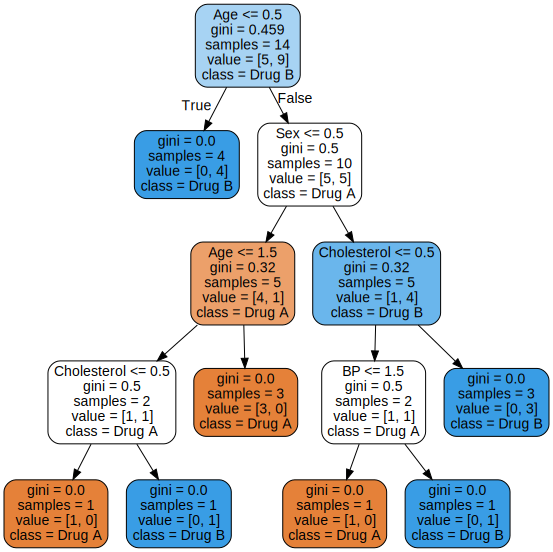

In [34]:
import graphviz
dot_data = tree.export_graphviz(dt,feature_names=feature_names,
                                class_names=class_names,
                                rounded=True,filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

In [35]:
# Dự đoán p15 - Hàm dựng
X_p15 = dfdata.iloc[14, 1:-1]
obs_row = X_p15.to_dict()
pred = predict(MyTree, obs_row)
print(f'Prediction for {obs_row}: {pred}')

Prediction for {'Age': 'Middle-age', 'Sex': 'F', 'BP': 'Low', 'Cholesterol': 'Normal'}: Drug A


In [36]:
# Dự đoán p15 - Hàm có sẵn
X1_p15 = X1_le.iloc[-1:]
pred = dt.predict(X1_p15)
print("Prediction for ")
print(f'{X1_p15}: {pred}')

Prediction for 
    Age  Sex  BP  Cholesterol
13    1    0   2            0: ['Drug A']


In [37]:
X1_a = X1_le.iloc[0:1]
X1_a

,Age,Sex,BP,Cholesterol
0,2,0,0,1


In [38]:
pred = dt.predict(X1_a)
print("Prediction for ")
print(f'{X1_p15}: {pred}')

Prediction for 
    Age  Sex  BP  Cholesterol
13    1    0   2            0: ['Drug A']


In [39]:
data_test_train = dfdata.iloc[:, 1:-1]
data_test_train

,Age,Sex,BP,Cholesterol
0,Young,F,High,Normal
1,Young,F,High,High
2,Middle-age,F,High,Normal
3,Senior,F,Normal,Normal
4,Senior,M,Low,Normal
5,Senior,M,Low,High
6,Middle-age,M,Low,High
7,Young,F,Normal,Normal
8,Young,M,Low,Normal
9,Senior,M,Normal,Normal


In [40]:
for index, row in data_test_train.iterrows():
    obs_row = [row[0], row[1], row[2], row[3]]
    pred = predict(MyTree, obs_row)
    print(f'Prediction for {obs_row}: {pred}')

TypeError: ignored